In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray
from matplotlib import pyplot as plt
import seaborn as sns
import codebase

In [2]:
from codebase import volume_pipeline

In [3]:
res_ref = codebase.load_data.load_formatted_usbr_data('Powell',monthly=True)
print(res_ref.columns)

Index(['Lake/Reservoir Area [acres]', 'Lake/Reservoir Bank Storage [af]',
       'Lake/Reservoir Change In Storage [af]',
       'Lake/Reservoir Elevation [ft]', 'Lake/Reservoir Evaporation [af]',
       'Lake/Reservoir Inflow - Unregulated [cfs]',
       'Lake/Reservoir Inflow Volume - Unregulated [af]',
       'Lake/Reservoir Inflow [af]', 'Lake/Reservoir Inflow [cfs]',
       'Lake/Reservoir Release - Bypass [af]',
       'Lake/Reservoir Release - Bypass [cfs]',
       'Lake/Reservoir Release - Powerplant [af]',
       'Lake/Reservoir Release - Powerplant [cfs]',
       'Lake/Reservoir Release - Spillway [cfs]',
       'Lake/Reservoir Release - Total [af]',
       'Lake/Reservoir Release - Total [cfs]', 'Lake/Reservoir Storage [af]'],
      dtype='object', name='Variable')


In [5]:
res_shp = codebase.load_data.load_GRanD()

In [6]:
# Volume pipeline with crs projection
dem_DA , fw_DA = volume_pipeline.create_aligned_DEM_CYGNSS_subsets('hoover',res_shp,epsg_code=54017)
fw_diff_DA = volume_pipeline.difference_over_time(fw_DA)
change_cond_DA = volume_pipeline.decide_expansion_or_shrinkage_vectorize(fw_diff_DA, input_core_dims = ['y','x'])
test_vol = volume_pipeline.calculate_rough_volume(dem_DA,fw_DA,fw_diff_DA,change_cond_DA,area_kwargs = {'input_core_dims' : [['y','x']], "vectorize": True})

## Area comparison

In [ ]:
res_ref_area_ac = res_ref['Lake/Reservoir Area [acres]']
res_ref_area_m2 = codebase.utils.convert_from_ac_to_m2(res_ref_area_ac)

In [14]:
res_calc_area_m2 = codebase.area_calcs.CYGNSS_001_area_calculation(fw_DA)

In [10]:
area_calc_match , area_ref_match = codebase.time_series_calcs.intersecting_timeframes(res_calc_area_m2,res_ref_area_m2,buffer=-1)

In [11]:
codebase.time_series_calcs.linregress_wrap(area_ref_match,area_calc_match.to_frame())

,slope,intercept,r_value,p_value,std_err
0,0.581138,391956897.722252,0.520645,0.000046,0.130901


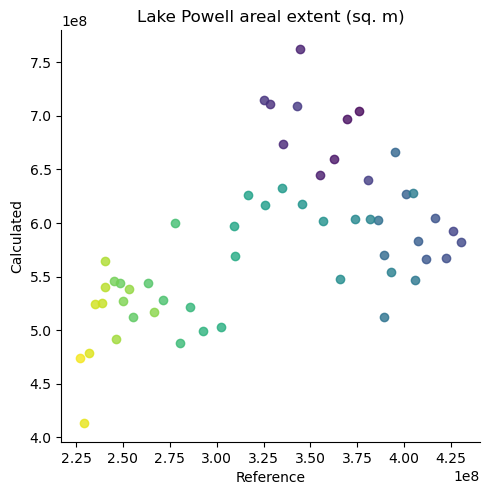

In [12]:
combo_area = pd.concat([area_calc_match, area_ref_match],axis=1)
combo_area.columns = ['Calculated','Reference']
combo_area.reset_index(inplace=True)

ax = sns.lmplot(x='Reference',y='Calculated',data=combo_area,fit_reg = True,hue='index',palette='viridis',legend=False)
plt.title('Lake Powell areal extent (sq. m)');